https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

https://huggingface.co/datasets/t4tiana/store-sales-time-series-forecasting/tree/main

In [ ]:
import pandas as pd

train_df = pd.read_parquet('library_ocupants_dataset/train-00000-of-00001.parquet')

print("Train Dataset Shape:", train_df.shape)
print("Column names:", train_df.columns.tolist())
print(train_df.head())

Train Dataset Shape: (84504, 7)
Column names: ['time', 'KTH Library', 'South-East Gallery', 'North Gallery', 'South Gallery', 'Ångdomen', 'Newton']
                  time  KTH Library  South-East Gallery  North Gallery  \
0  2024-12-09 18:16:16           35                  66             60   
1  2024-12-09 18:19:24           34                  66             59   
2  2024-12-09 18:22:31           32                  69             59   
3  2024-12-09 18:25:37           29                  66             56   
4  2024-12-09 18:28:44           29                  71             56   

   South Gallery  Ångdomen  Newton  
0             17        21      22  
1             14        19      22  
2             17        18      22  
3             26        19      22  
4             26        19      17  


In [39]:
# Select only numeric columns for normalization (exclude 'time')
numeric_cols = train_df.columns.drop('time')
raw_data = train_df[numeric_cols].values.astype('float32')

# Calculate split indices
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

print('num_train_samples:', num_train_samples)
print('num_val_samples:', num_val_samples)
print('num_test_samples:', num_test_samples)

# Normalize using only the training set statistics
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

num_train_samples: 42252
num_val_samples: 21126
num_test_samples: 21126


In [40]:
import numpy as np
from tensorflow import keras

# Use 'KTH Library' as the target series for demonstration
series = train_df['KTH Library'].values.astype(np.float32)

# We'll predict the next value given the previous 7 days
sequence_length = 7
batch_size = 256

# Prepare the dataset for time series forecasting
dataset = keras.utils.timeseries_dataset_from_array(
    data=series[:-sequence_length],
    targets=series[sequence_length:],
    sequence_length=sequence_length,
    batch_size=batch_size,  # adjust as needed
    shuffle=True
)

# Print a few example sequences and their targets
for inputs, targets in dataset.take(1):
    for i in range(inputs.shape[0]):
        print([float(x) for x in inputs[i]], float(targets[i]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[48.0, 47.0, 50.0, 52.0, 52.0, 52.0, 52.0] 54.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[6.0, 4.0, 5.0, 5.0, 4.0, 4.0, 4.0] 4.0
[32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0] 32.0
[19.0, 17.0, 20.0, 19.0, 19.0, 18.0, 19.0] 20.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[76.0, 75.0, 78.0, 79.0, 74.0, 70.0, 70.0] 70.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[12.0, 12.0, 12.0, 12.0, 13.0, 12.0, 12.0] 11.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[51.0, 53.0, 53.0, 52.0, 54.0, 54.0, 54.0] 55.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0] 0.0
[9.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0] 8.0
[5.0, 5.0, 7.0, 6.0, 6.0, 7.0, 7.0] 7.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [41]:
sampling_rate = 1  # daily data
delay = sequence_length  # predict the next value after the sequence

# Use normalized occupant data as features, and predict 'KTH Library' occupancy
features = raw_data  # already normalized, all columns except 'time'
targets = train_df['KTH Library'].values.astype('float32')

train_dataset = keras.utils.timeseries_dataset_from_array(
    data=features,
    targets=targets,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
    shuffle=True,
    start_index=0,
    end_index=num_train_samples
)
val_dataset = keras.utils.timeseries_dataset_from_array(
    data=features,
    targets=targets,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
    shuffle=True,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)
test_dataset = keras.utils.timeseries_dataset_from_array(
    data=features,
    targets=targets,
    sequence_length=sequence_length,
    sampling_rate=sampling_rate,
    batch_size=batch_size,
    shuffle=True,
    start_index=num_train_samples + num_val_samples
)

In [42]:
for samples, targets in train_dataset:
  print("samples shape:", samples.shape)
  print("targets shape:", targets.shape)
  break

samples shape: (256, 7, 6)
targets shape: (256,)


In [50]:
import matplotlib.pyplot as plt

def plot_training(history, model_name):
    loss = history.history['mae']
    val_loss = history.history['val_mae']
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, 'bo', label='Training MAE')
    plt.plot(epochs, val_loss, 'b', label='Validation MAE')
    plt.title(f'Training and validation MAE - {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Baseline

In [44]:
def evaluate_naive_method(dataset):
  total_abs_err = 0
  samples_seen = 0
  for samples, targets in dataset:
    preds = samples[:, -1, 1] * std[1] + mean[1]
    total_abs_err += np.sum(np.abs(preds - targets))
    samples_seen += samples.shape[0]
  return total_abs_err / samples_seen
print("Validation MAE (naive method):", evaluate_naive_method(val_dataset))
print("Test MAE (naive method):", evaluate_naive_method(test_dataset))

Validation MAE (naive method): 6.7642045
Test MAE (naive method): 4.758381


## Densely connected

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 787.6392 - mae: 15.0441 - val_loss: 667.4299 - val_mae: 15.2456
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 717.9270 - mae: 16.3128 - val_loss: 592.3749 - val_mae: 16.5321
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 636.4683 - mae: 17.8228 - val_loss: 562.5309 - val_mae: 18.5567
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 613.0399 - mae: 19.1642 - val_loss: 560.4858 - val_mae: 18.5102
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 612.9338 - mae: 19.2213 - val_loss: 559.0958 - val_mae: 18.5318
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 612.2933 - mae: 19.2811 - val_loss: 557.8932 - val_mae: 18.6243
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 607.7453 - mae: 19.2879 - val_loss: 557.3817 - val_mae: 18.8239
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 607.0822 - mae: 19.3846 - val_loss: 555.7613 - val_mae: 18.7040


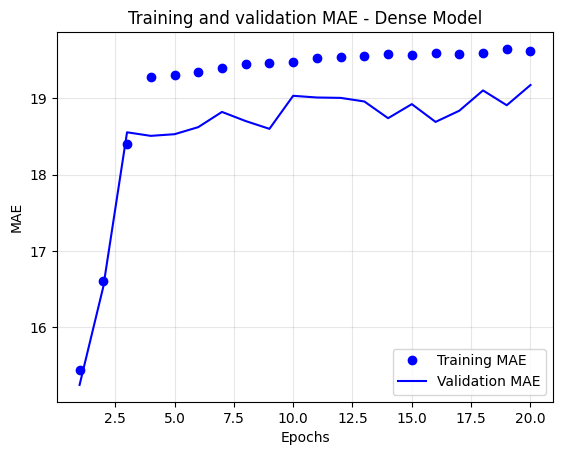

In [45]:
from tensorflow import keras
from tensorflow.keras import layers

num_epochs = 20

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
# Use Reshape instead of Flatten
x = layers.Reshape((-1, sequence_length * raw_data.shape[-1]))(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=num_epochs,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

plot_training(history, "Dense Model")

## 1D convolutional model

Epoch 1/20


166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 642.4862 - mae: 13.1496 - val_loss: 32.7587 - val_mae: 3.3033
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 24.8585 - mae: 2.9991 - val_loss: 13.8955 - val_mae: 2.5431
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 11.5159 - mae: 2.3056 - val_loss: 8.2406 - val_mae: 1.8205
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 7.2630 - mae: 1.6838 - val_loss: 5.5595 - val_mae: 1.3271
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 4.9924 - mae: 1.2770 - val_loss: 4.5508 - val_mae: 1.1483
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.5150 - mae: 0.9865 - val_loss: 3.3180 - val_mae: 0.8565
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.6803 - mae: 0.8172 - val_loss: 2.4286 - val_mae: 0.6751
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 2.1672 - mae: 0.6877 - val_loss: 2.7386 - val_mae: 0.8506
Epoch 9/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step

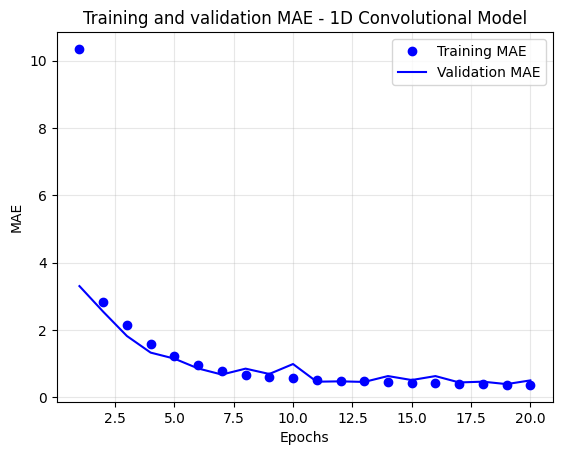

In [46]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 3, activation='relu', padding='same')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 3, activation='relu', padding='same')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("library_conv.keras",
                                    save_best_only=True)
]

model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=num_epochs,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("library_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

plot_training(history, "1D Convolutional Model")

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 762.8376 - mae: 14.3881 - val_loss: 580.7231 - val_mae: 11.8974
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 623.3854 - mae: 12.3530 - val_loss: 507.6867 - val_mae: 10.7197
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 550.0188 - mae: 11.2541 - val_loss: 450.9320 - val_mae: 9.9298
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 492.7816 - mae: 10.4867 - val_loss: 399.2129 - val_mae: 9.2228
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 440.5510 - mae: 9.7354 - val_loss: 351.1606 - val_mae: 8.4016
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 384.7661 - mae: 8.8689 - val_loss: 307.0651 - val_mae: 7.7409
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 337.7456 - mae: 8.1185 - val_loss: 266.8044 - val_mae: 7.0416
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 297.0797 - mae: 7.4906 - val_loss: 230.5139 - val_mae: 6.4224
Epoch 9/20

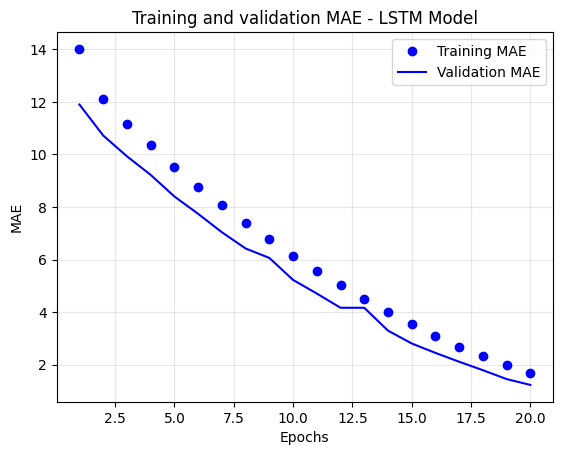

In [47]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [keras.callbacks.ModelCheckpoint("library_lstm.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("library_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

plot_training(history, "LSTM Model")

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 675.3185 - mae: 13.6247 - val_loss: 433.9908 - val_mae: 9.7520
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 465.6444 - mae: 10.2222 - val_loss: 340.4544 - val_mae: 8.5031
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 370.3215 - mae: 8.8837 - val_loss: 261.2737 - val_mae: 7.1078
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 287.5442 - mae: 7.6229 - val_loss: 196.4373 - val_mae: 6.1179
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 222.3798 - mae: 6.5595 - val_loss: 142.7688 - val_mae: 5.0543
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 167.8445 - mae: 5.6099 - val_loss: 100.2103 - val_mae: 3.9763
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 124.5218 - mae: 4.8019 - val_loss: 67.9456 - val_mae: 3.1910
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 93.6185 - mae: 4.1418 - val_loss: 44.0629 - val_mae: 2.5502
Epoch 9/20
166/16

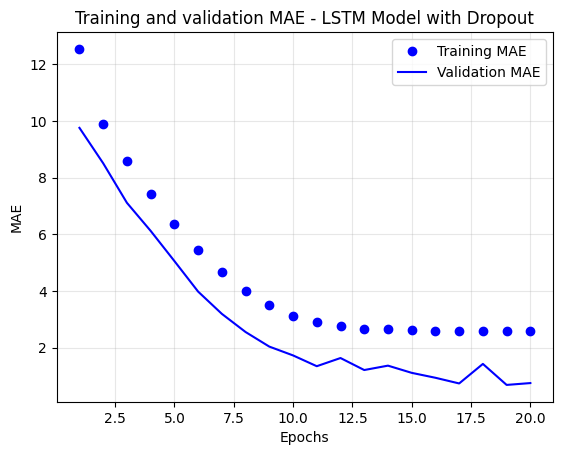

In [48]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1)(x)
model = keras.Model(inputs, output)

callbacks = [keras.callbacks.ModelCheckpoint("library_lstm_dropout.keras", save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("library_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

plot_training(history, "LSTM Model with Dropout")

Epoch 1/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 706.2468 - mae: 14.0748 - val_loss: 466.2538 - val_mae: 10.4805
Epoch 2/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 485.7777 - mae: 10.5088 - val_loss: 355.3294 - val_mae: 8.6204
Epoch 3/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 378.9464 - mae: 8.9402 - val_loss: 272.5825 - val_mae: 7.2995
Epoch 4/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 295.9913 - mae: 7.6072 - val_loss: 204.6246 - val_mae: 6.0766
Epoch 5/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 221.9268 - mae: 6.3197 - val_loss: 148.6876 - val_mae: 5.1555
Epoch 6/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 163.1040 - mae: 5.1757 - val_loss: 103.3511 - val_mae: 3.8841
Epoch 7/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 115.6537 - mae: 4.1536 - val_loss: 68.9498 - val_mae: 3.0392
Epoch 8/20
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 79.0015 - mae: 3.2848 - val_loss: 43.2874 - val_mae: 2.2834
Epoch 9/20
166/1

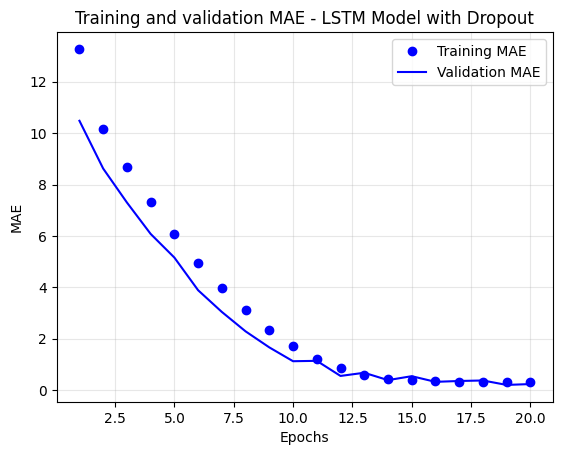

In [49]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs=inputs, outputs=outputs)

callbacks = [keras.callbacks.ModelCheckpoint("library_lstm_bidirecional.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset, callbacks=callbacks)
model = keras.models.load_model("library_lstm_bidirecional.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

plot_training(history, "LSTM Model with Dropout")